In [16]:
from dolfinx import mesh
import numpy as np
from mpi4py import MPI
import ufl
import gotranx
import monodomain 
import known_analytical
%reload_ext autoreload 

In [3]:
%autoreload
monodomain.translateODE("tentusscher_panfilov_2006_epi_cell", [gotranx.schemes.Scheme.generalized_rush_larsen])

2024-11-29 13:22:55 [info     ] Load ode /Users/alexanderhatle/Documents/Computing the Electrical Activity in the Heart/odes/tentusscher_panfilov_2006_epi_cell.ode
2024-11-29 13:22:55 [info     ] Num states 19                 
2024-11-29 13:22:55 [info     ] Num parameters 53             


In [3]:
def initial_v(x):
    return -85*np.cos(2*np.pi * x[0])

def initial_s(x):
    return 0*x[0]

def I_stim(x, t):
    condition = ufl.And(x[0]<0.5, x[1]<0.5)
    return 2 * ufl.sin(t) *ufl.conditional(condition, 60, 0)

In [6]:
%autoreload
def I_stim(x, t):
    condition = ufl.And(x[0]<0.1, ufl.And(t>0.5, t<4))
    return ufl.conditional(condition, 200, 0)

h = 0.05
dt = 0.01
theta = 0.5
M = ufl.tensors.as_matrix(np.eye(2))
pde = monodomain.PDESolver(h, dt, theta, M=M)

N = int(np.ceil(1/h))
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)
pde.set_mesh(domain, lagrange_order=2)
pde.set_stimulus(I_stim)
pde.setup_solver()
num_nodes = pde.V.dofmap.index_map.size_global
ode = monodomain.ODESolver(odefile="tentusscher_panfilov_2006_epi_cell", scheme="generalized_rush_larsen", num_nodes=num_nodes, v_name="V")
ode.set_param("stim_amplitude", 0)

solver = monodomain.MonodomainSolver(pde, ode)
vn, x, t = solver.solve(T=10)

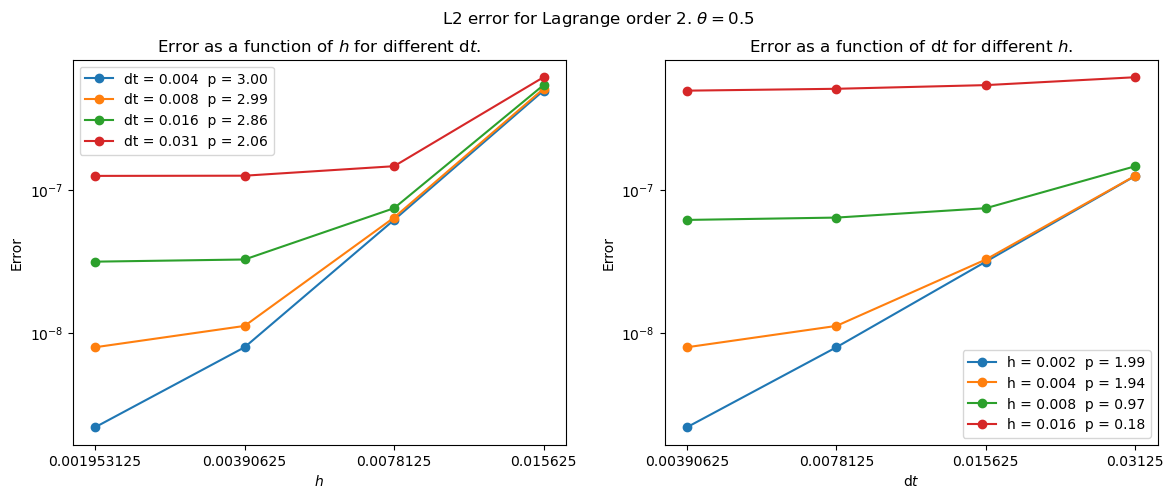

In [ ]:
%autoreload
hs = [1/(2**i) for i in range(9, 5, -1)]
dts = [1/(2**i) for i in range(8, 4, -1)]

known_analytical.convergence_plot(hs, dts, theta=0.5, T=2**-3, lagrange_order=2, plot_title="theta05_dual_convergence.png")

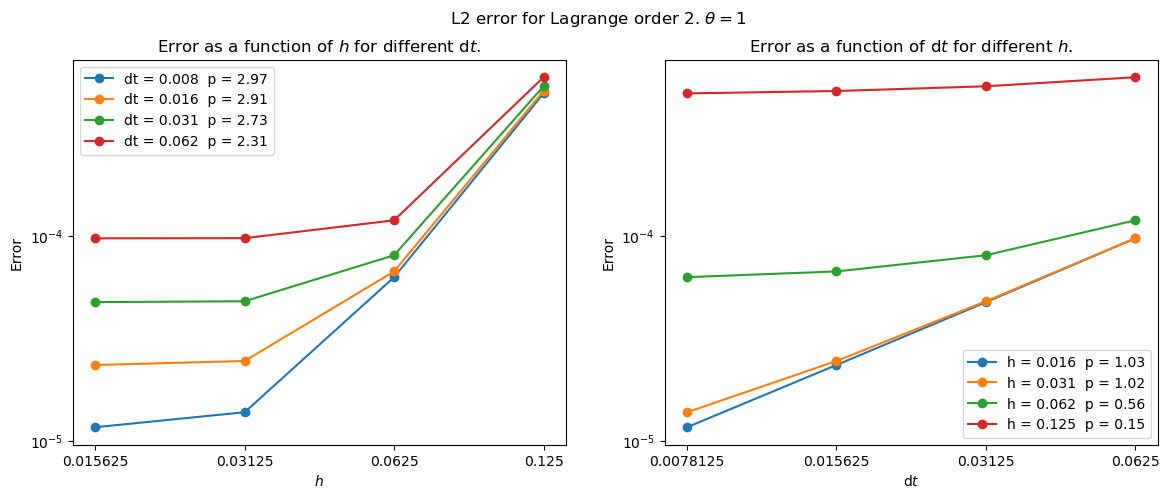

In [ ]:
%autoreload
hs = [1/(2**i) for i in range(6, 2, -1)]
dts = [1/(2**i) for i in range(7, 3, -1)]

known_analytical.convergence_plot(hs, dts, theta=1, lagrange_order=2, T=2**-2, plot_title="theta1_dual_convergence.png")